# Chapter 10: Predicting Continuous Target Variables with Regression Analysis

In [2]:
%matplotlib inline
import pandas as pd
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data',
                header=None, sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
             'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## scatterplot matrix

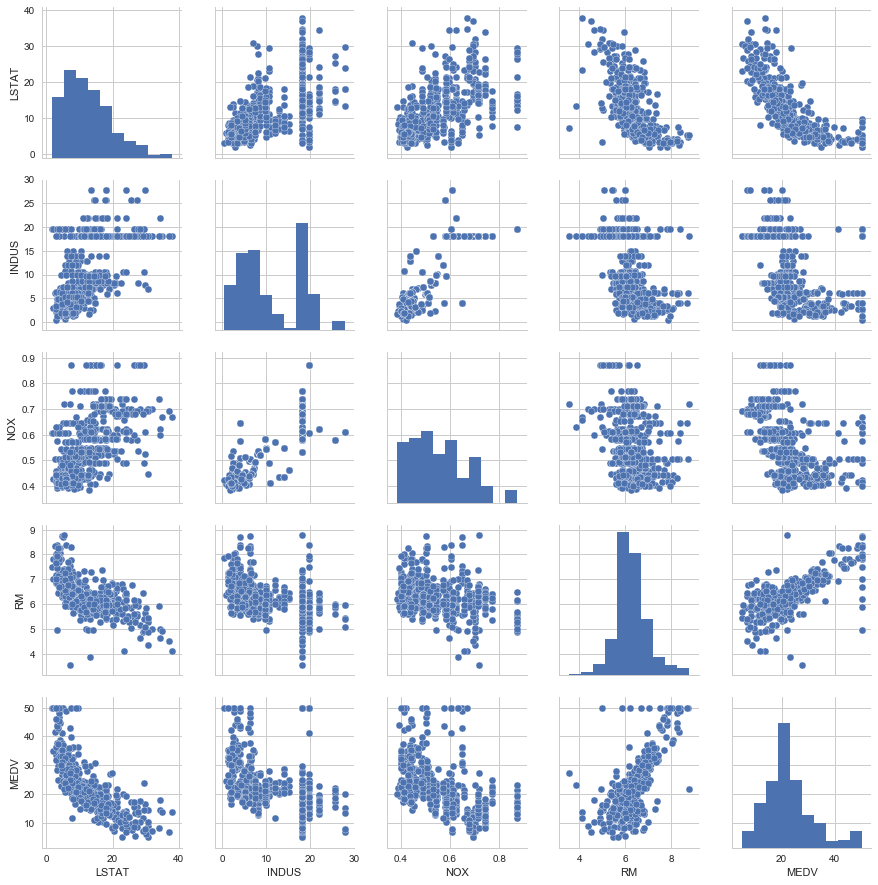

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], size=2.5)
plt.show()

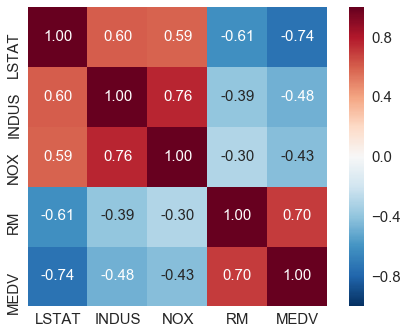

In [4]:
import numpy as np
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
                annot_kws={'size': 15}, yticklabels=cols, xticklabels=cols)
plt.show()

In [5]:
X = df[['RM']].values
y = df['MEDV'].values.reshape(-1, 1)
#y = y.reshape(-1, 1)
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y)
y_std = y_std[:, 0]
print(y.shape)


(506, 1)


In [6]:
# Indicate shape of numpy array
# w_ = np.zeros(1+X.shape[1])
# out_ = np.dot(X_std, w_[1:])+w_[0]
# err_ = (y_std - out_)
# print(w_.shape)
# print(out_.shape)
# print(err_.shape)
# print(df['MEDV'].shape)

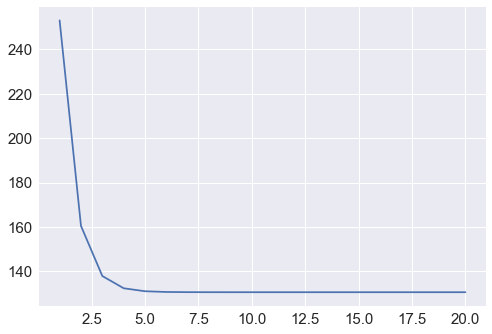

In [7]:
from LinearRegression import LinearRegressionGD
lr = LinearRegressionGD()
lr.fit(X_std, y_std)
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.show()

In [8]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='blue')
    plt.plot(X, model.predict(X), color='red')
    return None

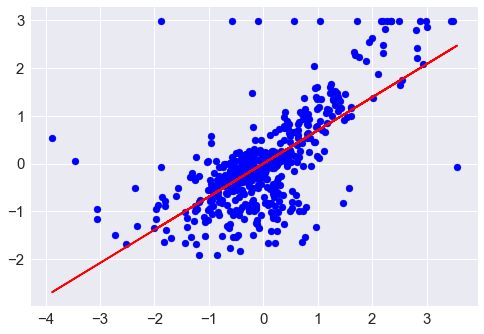

In [9]:
lin_regplot(X_std, y_std, lr)
plt.show()

In [10]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
print(slr.coef_)
print(slr.intercept_)

[[ 9.10210898]]
[-34.67062078]


## RANdom SAmple Consensus (RANSAC)

In [18]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(), max_trials=100,
                         min_samples=50, loss='absolute_loss',
                         residual_threshold=5.0, random_state=0)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_trials=100, min_samples=50, random_state=0,
        residual_metric=None, residual_threshold=5.0, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

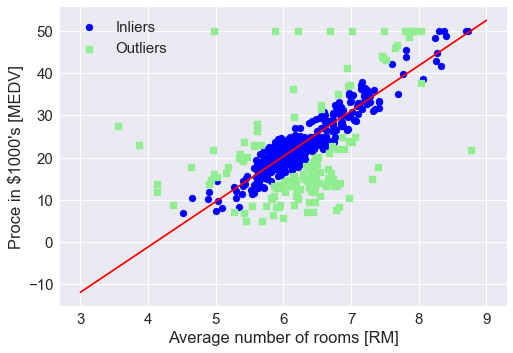

In [19]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask], c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask],  y[outlier_mask], c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Proce in $1000\'s [MEDV]')
plt.legend(loc='upper left')
plt.show()

In [20]:
print(ransac.estimator_.coef_)
print(ransac.estimator_.intercept_)

[[ 10.73450881]]
[-44.08906429]


In [21]:
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, random_state=0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

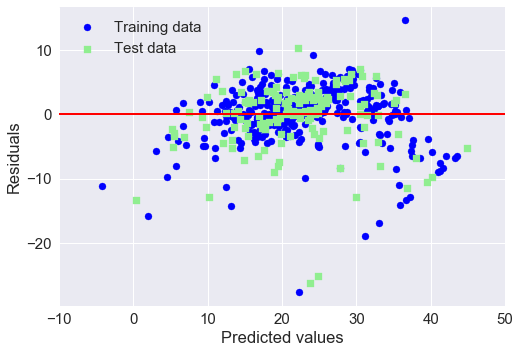

In [22]:
plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o',
           label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c='lightgreen', marker='s',
           label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.show()

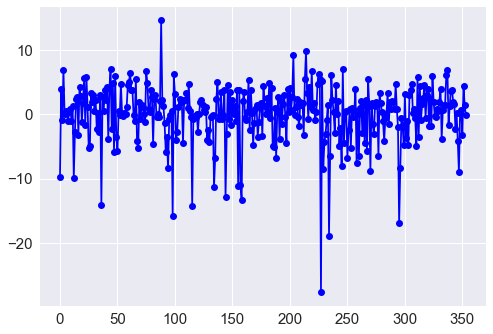

In [23]:
plt.plot(y_train_pred - y_train, c='blue', marker='o',
           label='Training data')

plt.show()

In [24]:
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f' % (
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196


In [25]:
from sklearn.metrics import r2_score
print('R^2 train: %.3f, test: %.3f' % (
    r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred)))

R^2 train: 0.765, test: 0.673


following code, regr fit 3 times, how does it work?

## Polynomial Regression

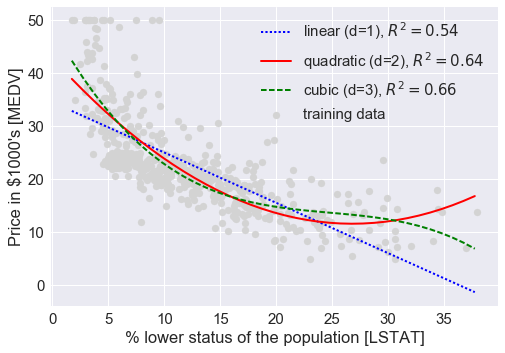

In [26]:
from sklearn.preprocessing import PolynomialFeatures
X = df[['LSTAT']].values
y = df['MEDV'].values
regr = LinearRegression()

quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]
regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

plt.scatter(X, y, label='training data', color='lightgray')
plt.plot(X_fit, y_lin_fit, label='linear (d=1), $R^2=%.2f$' % linear_r2,
        color='blue', lw=2, linestyle=':')
plt.plot(X_fit, y_quad_fit, label='quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
        color='red', lw=2, linestyle='-')
plt.plot(X_fit, y_cubic_fit, label='cubic (d=3), $R^2=%.2f$' % cubic_r2,
        color='green', lw=2, linestyle='--')
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper right')
plt.show()

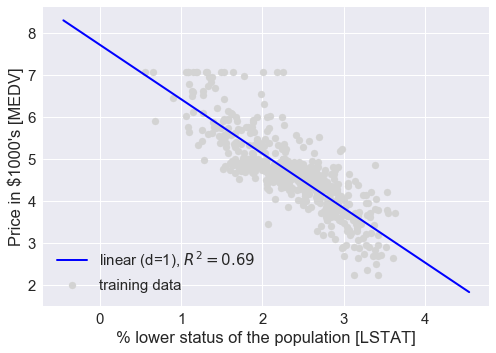

In [27]:
X_log = np.log(X)
y_sqrt = np.sqrt(y)

X_fit = np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]
regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

plt.scatter(X_log, y_sqrt, label='training data',
           color='lightgray')
plt.plot(X_fit, y_lin_fit, label='linear (d=1), $R^2=%.2f$' % linear_r2,
        color='blue', lw=2)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='lower left')
plt.show()

## Random forest regression

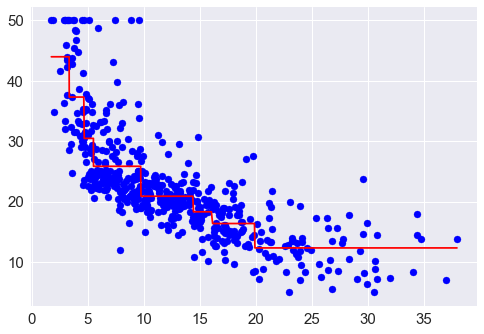

In [28]:
from sklearn.tree import DecisionTreeRegressor
X = df[['LSTAT']].values
y = df['MEDV'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.show()

In [29]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.4, random_state=1)
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000, criterion='mse',
                              random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
    r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred)))

MSE train: 1.642, test: 11.052
R^2 train: 0.979, test: 0.878


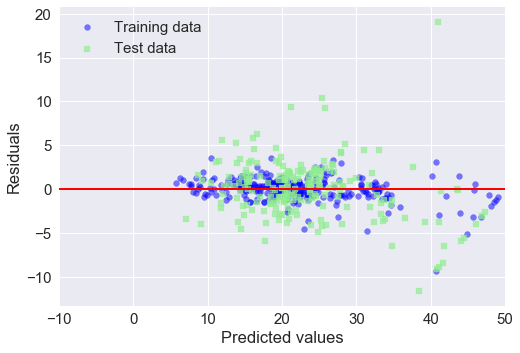

In [30]:
plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', s=35,
            alpha=0.5, label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c='lightgreen', marker='s', s=35,
            alpha=0.7, label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.show()

## Summary  
1. llnear regression
2. RANSAC
3. regularization
4. polynomial
5. random forest regressor